In [0]:
#opencv version 3.4.2.16
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

!pip install kmc2

!ls -lha kaggle.json
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

# 캐글연동을 위한 토큰 입력
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# 버전이 1.5.6 이 아니면, 진행할 수 없다
! kaggle -v

In [0]:
! kaggle competitions download -c 2019-ml-finalproject
! unzip 2019-ml-finalproject.zip

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from scipy.cluster.vq import vq
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import scale
import pandas as pd
import numpy as np
import math
import random
import cv2 
import os
import pickle

import kmc2
import cupy as xp
from svm import SVM
from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt
#from sklearn.svm import SVC

In [0]:
# 이미지 리사이즈
def resize(dir,step):
  img= cv2.imread(dir)
  img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_gray=cv2.resize(img_gray, (step,step))
  return img_gray 
#data load
def load_train_data(img_size,step_size):
  train_root_path="./train"
  len(os.listdir(train_root_path))
  train_data=[]
  label=[]
  train_des=[]
  cn=1
  for lis in tqdm(class_name):
  #for lis in tqdm(class_name[:25]):
    img_list=os.listdir(train_root_path+'/'+lis)
    for i in img_list:
      gray=resize(train_root_path+'/'+lis+'/'+i,img_size)
      train_des.append(dense_sift(gray,step_size))
      #train_data.append(gray)
      label.append(cn)
    cn+=1
  train_des=np.array(train_des)
  return train_des,label
def load_test_data(img_size,step_size):
  test_root_path="./testAll_v2"
  len(os.listdir(test_root_path))
  test_data=[]
  test_des=[]
  test_name=[]
  lis=os.listdir(test_root_path)
  lis.sort()
  for lis in tqdm(lis):
      gray=resize(test_root_path+'/'+lis,img_size)
      #test_data.append(gray)
      test_des.append(dense_sift(gray,step_size))
      test_name.append(lis)

  test_des=np.array(test_des)
  return test_des,test_name 
# SIFT weak feature extraction
def weak_sift(gray):
  sift=cv2.xfeatures2d_SIFT.create()
  kp,des=sift.detectAndCompute(gray,None)

  return des
#SIFT dense feature extraction
def dense_sift(gray,step):
  sift=cv2.xfeatures2d_SIFT.create()
  keypoints=[]
  w,h=gray.shape
  keypoints=[cv2.KeyPoint(i,j,step) for i in range(0,h,step) for j in range(0,w,step)]
  kp,des=sift.compute(gray,keypoints)
  
  return des 

def make_val(label,num):
  val_ind = []
  ran = random.randrange(0, 3031)
  for i in range(num) :
      while num in val_ind :
          num = random.randrange(0, 3031)
      val_ind.append(num)
  ind=[i for i in range(3031)]
  ind_=[item for item in ind if item not in val_ind]
  
  X1=train_des[ind_]
  X2=train_des[val_ind]
  y1=label[ind_]
  y2=label[val_ind]
  return X1,X2,y1,y2
################################
######## make histogram ########
################################
def histogram(data_set,size):
  train_his=[]
  for i in data_set:
    den=dense_sift(i,8)
    predict=Kmeans.predict(den)
    count=np.bincount(predict,minlength=size)
    train_his.append(count)
  return train_his
def histogram_vq(data_des):

  his=[]
  for i in tqdm(data_des):
    code_word=vq(i,codebook)[0]
    count=np.bincount(code_word,minlength=400)
    his.append(count)
  his=scale(his)
  return his  

def SPM_(L, des,codebooksize):
    des_cn=int(math.sqrt(des.shape[0]))
    ind_num=np.array(range(des.shape[0]))
    ind_num=ind_num.reshape(des_cn,des_cn)
    h = []
    for l in  range(L+1):      #레벨별 실행
        des_step = int(des_cn/(2**l))
        x, y = 0, 0
        for i in range(1,2**l + 1):   #가로세로 이중포문
            x = 0
            for j in range(1, 2**l + 1):     
                ind=ind_num[x:x+des_step,y:y+des_step]  
                ind=ind.reshape(-1)     
                desc = des[ind,:]
                #print("type:",desc is None, "x:",x,"y:",y, "desc_size:",desc is None)
                code_word=vq(desc,codebook)[0]
                count=np.bincount(code_word,minlength=codebooksize)
                if l == 0:
                    weight = 2**(l- L);
                else:
                    weight = 2**(l- L -1);
                h.append(weight*count)
                x = x + des_step
            y = y + des_step
          #h=scale(h)
    hist = np.array(h).reshape(-1)
    return hist

def histogram_spm(L, data,codebooksize):    
    x = []
    for desi in tqdm(data):        
        hist = SPM_(L, desi,codebooksize)        
        x.append(hist)
    return np.array(x)
############################
####### train method #######
############################
def SVM_GPU(X_train,X_val,y_train,C):
  X_train = xp.asarray(X_train)
  X_val = xp.asarray(X_val)
  y_train = xp.asarray(y_train)

  #svm = SVM(kernel='linear', kernel_params={'sigma': 15}, classification_strategy='ovr', x=X_train, y=y_train)
  svm = SVM(kernel='linear',classification_strategy='ovr', kernel_params={'C':1},x=X_train, y=y_train)

  svm.fit(X_train, y_train)

  val_fit=svm.predict(X_val)
  val_fit=xp.asnumpy(val_fit)
  '''
  test_h = xp.asarray(test_h)
  result=svm.prdict(test_h)
  result=xp.asnumpy(result)
  '''
  return result, val_fit

def SVM_Grid(X_train,X_val,y_train,test_h,c,g):

  svm = SVC(kernel='rbf')
  param_grid = {'C':c,'gamma':g}
  grid = GridSearchCV(svm, param_grid, cv=5)

  grid.fit(X_train,y_train)
  print(grid.best_params_)
  val_fit=grid.predict(X_val)
  result=grid.predict(test_h)
  return result, val_fit

def SVM_Grid_val(X_train,X_val,y_train,c,g):

  svm = SVC(kernel='rbf',class_weight='balanced')
  param_grid = {'C':c,'gamma':g}
  grid = GridSearchCV(svm, param_grid, cv=5)

  grid.fit(X_train,y_train)
  print(grid.best_params_)
  val_fit=grid.predict(X_val)
  return  val_fit

def SVM_(X_train,X_val,y_train,test_h,c,g):
  svm = SVC(kernel='rbf',class_weight='balanced',C=c,gamma=g)
  svm.fit(X_train,y_train)
  val_fit=svm.predict(X_val)
  result=svm.predict(test_h)
  return result, val_fit

def SVM_val(X_train,X_val,y_train,c):
  svm = SVC(kernel='linear',C=c)
  svm.fit(X_train,y_train)
  val_fit=svm.predict(X_val)
  return val_fit

def DT(X_train,X_val,y_train,test_h,n):
  model=DecisionTreeClassifier()
  bag=BaggingClassifier(model,n_estimators=n)
  bag.fit(X_train,y_train)
  val_fit=bag.predict(X_val)
####################
####### data #######
####################
def make_result_csv(result,test_name):
  result_=np.append(['Category'],result)
  result_id=np.append(['Id'],test_name)
  df = pd.DataFrame(result_,result_id,columns=[' '])
  df.to_csv('results_.csv',index=True, header=False)
  print(df)

def save_array(file_name,arr):
  with open(file_name,'wb') as f:
    pickle.dump(arr,f)
def load_array(file_name):
  with open(file_name,'rb') as f:
    arr=pickle.load(f)
  return arr

In [0]:
df_data=pd.read_csv('/content/Label2Names.csv',header=None)
class_name=df_data[1].tolist()
#class_name.append('BACKGROUND_Google')
df_data

,0,1
0,1,Faces
1,2,Faces_easy
2,3,Leopards
3,4,Motorbikes
4,5,accordion
...,...,...
96,97,wheelchair
97,98,wild_cat
98,99,windsor_chair
99,100,wrench


In [0]:
train_des,label=load_train_data(256,8)
test_des,test_name=load_test_data(256,8)

100%|██████████| 1692/1692 [01:37<00:00, 17.36it/s]


In [0]:
des_vec=train_des.reshape(-1,128)
print("train_des : ",train_des.shape)
print("test_des : ",test_des.shape)
print("des_vec : ",des_vec.shape)

train_des :  (3030, 1024, 128)
test_des :  (1692, 1024, 128)
des_vec :  (3102720, 128)


In [0]:
codebooksize=400
seeding = kmc2.kmc2(des_vec, codebooksize) 
Kmeans = MiniBatchKMeans(codebooksize, init=seeding,init_size=codebooksize).fit(des_vec)
codebook = Kmeans.cluster_centers_
print("codebook : ",codebook.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3
  This is separate from the ipykernel package so we can avoid doing imports until


codebook :  (400, 128)


In [0]:
histogram_vq
h_list = histogram_vq(train_des)
test_h = histogram_vq(test_des)

100%|██████████| 1692/1692 [00:05<00:00, 301.28it/s]


In [0]:
h_list.shape

(3030, 400)

<BarContainer object of 400 artists>

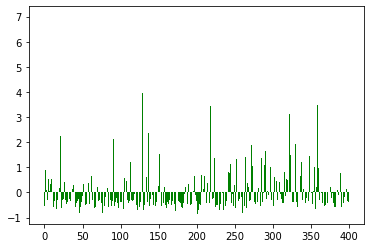

In [0]:

histo_plt=h_list[0]
plt.bar(range(codebooksize),histo_plt , color='g')


In [0]:
#result,val_fit=SVM_Grid(h_list,val_h,y1,test_h,[4,10,12],[0.05,0.001,0.0008])
results=SVM_Grid_val(h_list,test_h,label,[1,4,10],[0.01,0.001,0.0001])

##result,val_fit=SVM_(h_list,val_h,y1,test_h, 4, 0.001)
#results=SVM_val(h_list,test_h,label,1)


#result,val_fit=SVM_GPU(X_train,X_val,y_train,1)
#result,val_fit=SVM_GPU(X_train,X_val,y_train,test_h,1)
#result=DT(X_train,X_val,y_train,test_h,1000)

{'C': 4, 'gamma': 0.001}


In [0]:
make_result_csv(results,test_name)

                        
Id              Category
image_0001.jpg        54
image_0002.jpg        89
image_0003.jpg        92
image_0004.jpg        34
...                  ...
image_1688.jpg        11
image_1689.jpg        61
image_1690.jpg        29
image_1691.jpg        45
image_1692.jpg        35

[1693 rows x 1 columns]


In [0]:
! kaggle competitions submit -c 2019-ml-finalproject -f results_.csv -m "sanhee-1213_pca"

100% 29.6k/29.6k [00:00<00:00, 97.5kB/s]
Successfully submitted to 2019.Fall.PatternRecognition 